In [1]:
from sqlalchemy import create_engine, text 
import pandas as pd 
import dbutils as db 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

## Domande sui dati
1. Determinare il gradimento medio per autore
2. Gradimento medio per autore (mostrando la distribuzione dei valori) 
3. Definire un profilo degli utenti sulla base del loro gradimento per il genere letterario, considerando sia il numero di voti sia il valore del voto.
4. Raggruppare gli utenti con simili profili di interessi per i generi letterari 
5. Preso un utente, suggerire un libro che non ha letto sulla base del gradimento per i vari libri da parte di utenti con il profilo simile
   
```
book(id, title, pages, author, rating_count, description)
rating(book, user, rating)
genre(book, genre)
```

In [2]:
engine = create_engine("sqlite:////Users/flint/Data/kaggle/books/book-recommender/booksdb.sql")

#### 1. Gradimento medio per autore

In [3]:
sql_1 = """
SELECT B.author, AVG(R.rating) AS avg_rating, COUNT(*) AS num_ratings
FROM rating AS R JOIN books AS B
ON R.book = B.id
GROUP BY B.author
""" 
sql_1bis = """
SELECT B.author, R.rating
FROM rating AS R JOIN books AS B
ON R.book = B.id
""" 

In [4]:
answer_1 = db.search(sql=sql_1, engine=engine)

In [5]:
answer_1.sort_values('avg_rating', ascending=False).head(2)

,author,avg_rating,num_ratings
6,Cassandra Clare,4.439496,119
61,R.J. Palacio,4.390110,182


In [6]:
answer_1.head(2)

,author,avg_rating,num_ratings
0,Abbi Glines,4.161078,167
1,Alex Flinn,3.540132,152


In [7]:
answer_1bis = db.search(sql=sql_1bis, engine=engine)

In [8]:
answer_1bis.groupby('author').agg(['mean', 'std'])

rating          
                         mean       std
author                                 
Abbi Glines          4.161078  0.762830
Alex Flinn           3.540132  0.649224
Art Spiegelman       4.238849  0.549771
Becca Fitzpatrick    3.889796  0.706303
Brandon Sanderson    4.362000  0.554828
...                       ...       ...
Tom Clancy           3.826119  0.729603
Tony Moore           4.210256  0.480012
Ursula K. Le Guin    3.795876  0.672312
Veronica Roth        3.991489  0.618298
William Shakespeare  4.165672  0.616577

[83 rows x 2 columns]

#### 2. Distribuzione dei valori di rating per autore

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

In [10]:
sql_2 = """
SELECT B.author, R.rating
FROM rating AS R JOIN books AS B
ON R.book = B.id
WHERE B.author in ('Douglas Adams', 'Markus Zusak')
""" 

In [11]:
answer_2 = db.search(sql=sql_2, engine=engine)

In [12]:
answer_2.head(2)

,author,rating
0,Douglas Adams,2.5
1,Douglas Adams,2.7


In [13]:
answer_2bis = db.search(sql_1, engine=engine)

In [14]:
answer_2bis.head(5)

,author,avg_rating,num_ratings
0,Abbi Glines,4.161078,167
1,Alex Flinn,3.540132,152
2,Art Spiegelman,4.238849,139
3,Becca Fitzpatrick,3.889796,98
4,Brandon Sanderson,4.362000,100


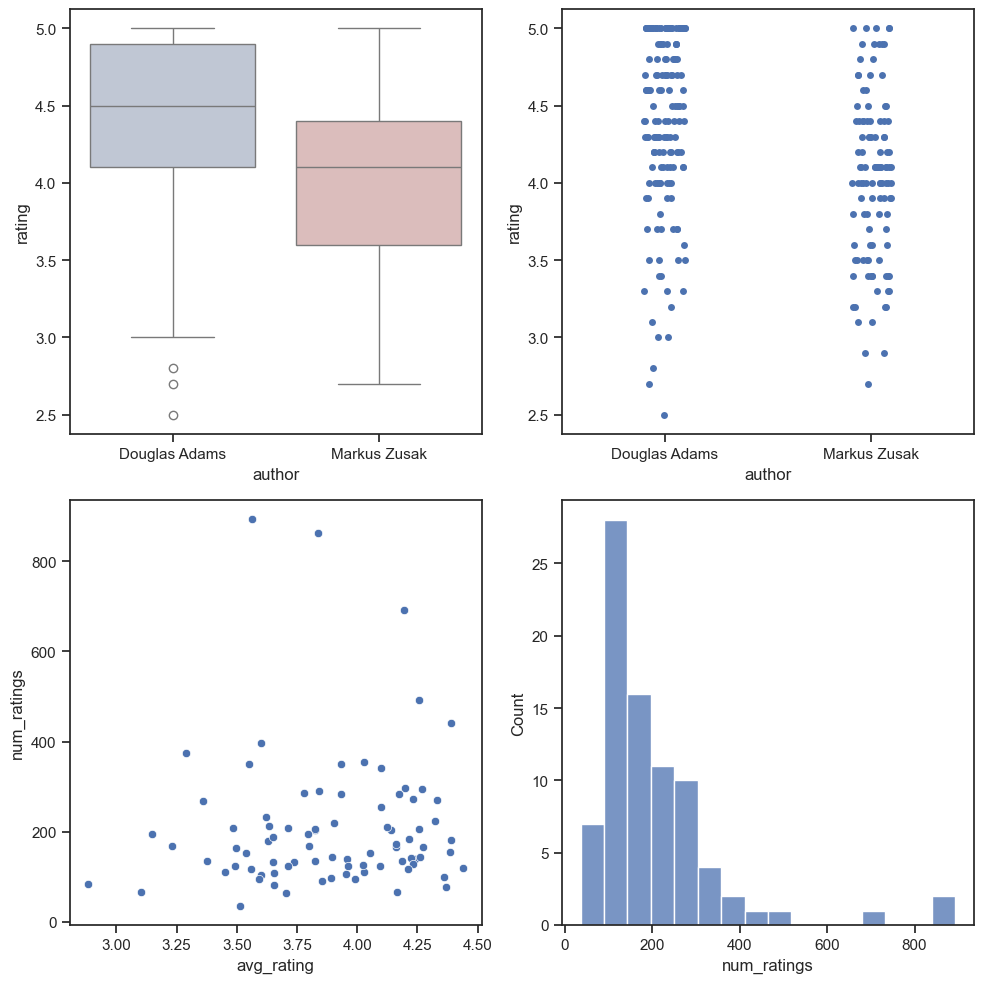

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)
sns.boxplot(answer_2, x='author', y='rating', 
            palette="vlag", hue='author', ax=ax[0, 0])
sns.stripplot(answer_2, ax=ax[0, 1], x='author', y='rating')
sns.scatterplot(answer_2bis, x='avg_rating', 
                y='num_ratings', ax=ax[1, 0])
sns.histplot(answer_2bis, x='num_ratings', ax=ax[1, 1])
plt.tight_layout()
plt.show()

#### 3. Definire un profilo degli utenti sulla base del loro gradimento per il genere letterario, considerando sia il numero di voti sia il valore del voto.
```
book(id, title, pages, author, rating_count, description)
rating(book, user, rating)
genre(book, genre)
```

In [16]:
sql_3 = """
SELECT R.user, G.genre, SUM(R.rating) AS score
FROM rating AS R JOIN genre AS G
ON R.book = G.book
GROUP BY R.user, G.genre
""" 

In [17]:
answer_3 = db.search(sql_3, engine=engine)

In [18]:
answer_3.head(10)

,user,genre,score
0,0,biography,10.5
1,0,children,2.8
2,0,comics,7.5
3,0,crime,5.8
4,0,fantasy,3.0
5,0,fiction,10.5
6,0,graphic,7.5
7,0,historical fiction,10.5
8,0,history,10.5
9,0,mystery,5.8


In [19]:
answer_3[answer_3.user == 4580]

,user,genre,score
7171,4580,children,4.0
7172,4580,crime,5.0
7173,4580,fantasy,9.0
7174,4580,fiction,9.0
7175,4580,mystery,5.0
7176,4580,paranormal,9.0
7177,4580,romance,9.0
7178,4580,thriller,5.0
7179,4580,young-adult,9.0


In [20]:
genre_list = list(answer_3.genre.unique())
user_list = list(answer_3.user.unique())
profile_matrix = np.zeros((len(user_list), len(genre_list)))

In [21]:
for i, row in answer_3.iterrows():
    u, s, g = row['user'], row['score'], row['genre']
    user_index = user_list.index(u)
    genre_index = genre_list.index(g)
    profile_matrix[user_index, genre_index] = s

**Scaling data**

In [22]:
scaler = MinMaxScaler()
profile_matrix = scaler.fit_transform(profile_matrix)
profile_matrix

array([[1.        , 0.18918919, 0.51724138, ..., 0.47933884, 0.55555556,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.26446281, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2010582 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2010582 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.26455026,
        0.        ]])

In [23]:
profile = pd.DataFrame(profile_matrix, 
                    index=user_list, columns=genre_list)

In [24]:
profile

,biography,children,comics,crime,fantasy,fiction,graphic,historical fiction,history,mystery,non-fiction,paranormal,romance,thriller,young-adult,poetry
0,1.0,0.189189,0.517241,0.479339,0.172414,0.555556,0.517241,1.0,1.0,0.479339,0.581395,0.172414,0.158730,0.479339,0.555556,0.0
1,0.0,0.000000,0.000000,0.264463,0.000000,0.169312,0.000000,0.0,0.0,0.264463,0.000000,0.000000,0.000000,0.264463,0.000000,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.201058,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.201058,0.000000,0.201058,0.0
4,0.0,0.000000,0.000000,0.000000,0.189655,0.174603,0.000000,0.0,0.0,0.000000,0.000000,0.189655,0.174603,0.000000,0.000000,0.0
7,0.0,0.297297,0.000000,0.000000,0.252874,0.232804,0.000000,0.0,0.0,0.000000,0.000000,0.252874,0.232804,0.000000,0.232804,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83971,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0
84075,0.0,0.000000,0.000000,0.000000,0.241379,0.222222,0.000000,0.0,0.0,0.000000,0.000000,0.241379,0.000000,0.000000,0.222222,0.0
84107,0.0,0.000000,0.000000,0.000000,0.000000,0.089947,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.089947,0.000000,0.000000,0.0
84228,0.0,0.000000,0.000000,0.000000,0.000000,0.201058,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.201058,0.000000,0.201058,0.0


In [25]:
profile_matrix[0]

array([1.        , 0.18918919, 0.51724138, 0.47933884, 0.17241379,
       0.55555556, 0.51724138, 1.        , 1.        , 0.47933884,
       0.58139535, 0.17241379, 0.15873016, 0.47933884, 0.55555556,
       0.        ])

In [40]:
profile.loc[0]

biography             1.000000
children              0.189189
comics                0.517241
crime                 0.479339
fantasy               0.172414
fiction               0.555556
graphic               0.517241
historical fiction    1.000000
history               1.000000
mystery               0.479339
non-fiction           0.581395
paranormal            0.172414
romance               0.158730
thriller              0.479339
young-adult           0.555556
poetry                0.000000
Name: 0, dtype: float64

In [26]:
profile_matrix[1]

array([0.        , 0.        , 0.        , 0.26446281, 0.        ,
       0.16931217, 0.        , 0.        , 0.        , 0.26446281,
       0.        , 0.        , 0.        , 0.26446281, 0.        ,
       0.        ])

**User similarity**

In [27]:
from sklearn.metrics import pairwise_distances

In [28]:
sigma = pairwise_distances(profile_matrix, profile_matrix)

In [29]:
S = pd.DataFrame(sigma, index=user_list, columns=user_list)

In [41]:
S

,0,1,3,4,7,9,11,12,21,33,...,83482,83532,83533,83695,83815,83971,84075,84107,84228,84290
0,0.000000,2.142400,2.216025,2.247844,2.191085,2.136077,2.209998,2.064645,2.210414,1.339375,...,1.529199,2.194814,2.115671,2.190318,2.199592,2.266463,2.203433,2.277675,2.216025,2.199592
1,2.142400,0.000000,0.540073,0.558815,0.733842,0.635248,0.579562,0.415821,0.592546,1.028556,...,1.077271,0.705309,0.137349,0.707718,0.599054,0.480552,0.615249,0.473509,0.540073,0.599054
3,2.216025,0.540073,0.000000,0.337287,0.468294,0.455513,0.343034,0.609124,0.317416,1.246617,...,0.973425,0.519024,0.652338,0.556546,0.109971,0.217254,0.397301,0.255178,0.000000,0.109971
4,2.247844,0.558815,0.337287,0.000000,0.396675,0.395796,0.477514,0.566384,0.252767,1.170407,...,1.027101,0.439509,0.669821,0.512651,0.397625,0.271944,0.295783,0.293720,0.337287,0.397625
7,2.191085,0.733842,0.468294,0.396675,0.000000,0.507510,0.427788,0.613393,0.209838,1.231459,...,1.090887,0.233164,0.818149,0.502257,0.468294,0.535401,0.378248,0.557934,0.468294,0.468294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83971,2.266463,0.480552,0.217254,0.271944,0.535401,0.463494,0.386909,0.644106,0.343100,1.226034,...,0.981245,0.558915,0.608555,0.558204,0.315603,0.000000,0.438882,0.074826,0.217254,0.315603
84075,2.203433,0.615249,0.397301,0.295783,0.378248,0.331078,0.439691,0.567353,0.287341,1.170886,...,1.015627,0.305855,0.714410,0.473136,0.436002,0.438882,0.000000,0.437605,0.397301,0.436002
84107,2.277675,0.473509,0.255178,0.293720,0.557934,0.456189,0.384732,0.657015,0.354339,1.226947,...,0.968610,0.559416,0.607173,0.551138,0.361883,0.074826,0.437605,0.000000,0.255178,0.361883
84228,2.216025,0.540073,0.000000,0.337287,0.468294,0.455513,0.343034,0.609124,0.317416,1.246617,...,0.973425,0.519024,0.652338,0.556546,0.109971,0.217254,0.397301,0.255178,0.000000,0.109971


In [30]:
S.loc[0].sort_values(ascending=True)

0        0.000000
60109    0.525742
37050    0.549468
65668    0.556369
28026    0.599122
           ...   
12530    2.358428
24788    2.361610
2985     2.388332
588      2.450653
27010    2.491241
Name: 0, Length: 15039, dtype: float64

In [43]:
profile.loc[0].sort_values(ascending=False)

biography             1.000000
historical fiction    1.000000
history               1.000000
non-fiction           0.581395
fiction               0.555556
young-adult           0.555556
comics                0.517241
graphic               0.517241
crime                 0.479339
mystery               0.479339
thriller              0.479339
children              0.189189
fantasy               0.172414
paranormal            0.172414
romance               0.158730
poetry                0.000000
Name: 0, dtype: float64

In [44]:
profile.loc[60109].sort_values(ascending=False)

biography             0.961905
historical fiction    0.961905
history               0.961905
non-fiction           0.558140
fiction               0.534392
comics                0.496552
graphic               0.496552
young-adult           0.380952
poetry                0.322222
crime                 0.289256
mystery               0.289256
thriller              0.289256
children              0.236486
fantasy               0.166667
paranormal            0.166667
romance               0.000000
Name: 60109, dtype: float64

In [45]:
profile.loc[588].sort_values(ascending=False)

fantasy               0.804598
paranormal            0.804598
fiction               0.740741
romance               0.740741
young-adult           0.740741
children              0.675676
biography             0.000000
comics                0.000000
crime                 0.000000
graphic               0.000000
historical fiction    0.000000
history               0.000000
mystery               0.000000
non-fiction           0.000000
thriller              0.000000
poetry                0.000000
Name: 588, dtype: float64